# LA-ICP-MS classification of polymer objects

In [1]:
import copy, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

from scipy.stats import gaussian_kde
from scipy.spatial.distance import pdist, squareform

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

from tqdm.auto import tqdm

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

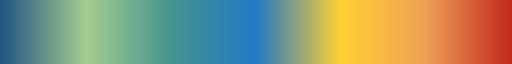

In [3]:
#Design colormap
mycolors2 = ["#215584","#A5CD90"]
mycolors3 = ["#215584","#A5CD90","#C22A1E"]
mycolors4 = ["#215584","#A5CD90","#F0A058","#C22A1E"]
mycolors5 = ["#215584","#2379C7","#A5CD90","#F0A058","#C22A1E"]
mycolors6 = ["#215584","#A5CD90","#44948F","#2379C7","#F0A058","#C22A1E"]
mycolors7 = ["#215584","#A5CD90","#44948F","#2379C7","#FFD133","#F0A058","#C22A1E"]
mycolors8 = ["#215584","#A5CD90","#44948F","#2379C7","#FFD133","#F0A058","#C22A1E",'black']
sns.set_palette(mycolors5)
mycmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", mycolors2)
mycmap3 = matplotlib.colors.LinearSegmentedColormap.from_list("", mycolors3)
mycmap4 = matplotlib.colors.LinearSegmentedColormap.from_list("", mycolors4)
mycmap5 = matplotlib.colors.LinearSegmentedColormap.from_list("", mycolors5)
mycmap6 = matplotlib.colors.LinearSegmentedColormap.from_list("", mycolors6)
mycmap7 = matplotlib.colors.LinearSegmentedColormap.from_list("", mycolors7)
mycmap8 = matplotlib.colors.LinearSegmentedColormap.from_list("", mycolors8)
mycmap7

## Import data

### Select dataset

Open the csv file with the data which you want to analyze. The following options are possible:
* Data_Polymers (uncorrected data)
* Data_Polymers_C (data normalized to C signal)
* Data_Polymers_glass (data (semi-)quantified with NIST SRM 612 standard, raw signal divided by signal standard)
* Data_Polymers_PVC (data quantified with PVC standard in mg/kg)
* Data_Polymers_PVC_C (data normalized to C signal and (semi-)quantified with PVC standard in mg/kg)

In [4]:
data_FO_processed = (pd.read_csv('df/Data_Polymers.csv', sep = ',')).pivot_table(index=["Polymer", "Source","Day2","Batch","Color","N"])
data_FO_processed

Al27         As75          Ba138  \
Polymer Source Day2 Batch Color  N                                             
Can     1      1    A     Black  1  4.514513e+05  2424.022697   86832.257747   
                                 2  2.649830e+05  2010.655483  113244.518728   
                                 3  3.659630e+05  1982.227454  126763.638529   
                                 4  2.403186e+05  2078.278705   85428.380212   
               2    A     Black  1  4.742555e+05   454.148398   74589.797046   
...                                          ...          ...            ...   
Wire    49     1    A     Yellow 4  6.260520e+05  2449.337480   38155.721808   
               2    A     Yellow 1  7.211286e+05  1918.783449   52927.602727   
                                 2  1.268050e+06  2072.578929   83856.410263   
                                 3  6.270178e+05  1772.158243   40769.225489   
                                 4  6.816793e+05  1463.358616   37683.452751   

                                            Ca44           Cu63          Fe57  \
Polymer Source Day2 Batch Color  N                                              
Can     1      1    A     Black  1  1.156666e+06   98427.319507  36682.518303   
                                 2  1.192630e+06  101432.243981  32799.164407   
                                 3  1.179015e+06  100321.324477  45477.240574   
                                 4  1.205820e+06   97302.642666  44369.432417   
               2    A     Black  1  9.902725e+05   89048.742400  43832.276618   
...                                          ...            ...           ...   
Wire    49     1    A     Yellow 4  4.420022e+07   14561.255521  80812.833536   
               2    A     Yellow 1  4.210882e+07   14997.490717  77099.098742   
                                 2  4.983738e+07   19201.416678  87897.146067   
                                 3  4.757561e+07   22478.465137  87302.818301   
                                 4  4.503496e+07   12912.982289  81029.085051   

                                             K39           Mg25  \
Polymer Source Day2 Batch Color  N                                
Can     1      1    A     Black  1  2.673996e+05   12105.466885   
                                 2  1.375284e+05   12876.598394   
                                 3  1.754441e+05   10404.698679   
                                 4  1.038278e+05    9366.842277   
               2    A     Black  1  2.112191e+05   13120.011733   
...                                          ...            ...   
Wire    49     1    A     Yellow 4  4.484523e+05  666638.362292   
               2    A     Yellow 1  5.741748e+05  750185.849410   
                                 2  1.049662e+06  766291.161143   
                                 3  4.731333e+05  733973.700897   
                                 4  4.203999e+05  676966.875409   

                                             Mn55           Na23  \
Polymer Source Day2 Batch Color  N                                 
Can     1      1    A     Black  1   44082.572733   56841.704042   
                                 2   39485.795384   48238.705174   
                                 3   53590.660179   66655.715274   
                                 4   55179.628033   42589.440131   
               2    A     Black  1   34579.652692   59406.208408   
...                                           ...            ...   
Wire    49     1    A     Yellow 4  137095.732325  241226.265339   
               2    A     Yellow 1  123392.992913  272082.121049   
                                 2  140573.952415  350748.483015   
                                 3  155588.712507  267475.081084   
                                 4  123298.645865  225408.827133   

                                            Nb93         Ni60         Pb208  \
Polymer Source Day2 Batch Color  N                                            
Can     1      1    A     Black  1

In this step the specific type of object can be selected and the number of elements.

In [5]:
# Select dataset with specific normalization and quantification method
data_FO_select = data_FO_processed

#Select elements and type of forensic object: tapes, wires, tubing, (Jerry) Can
data_x = (data_FO_select
              .reset_index()
              .pivot_table(index=['Polymer', 'Source','Day2', 'Batch', "Color", 'N'])
              .sort_values(["Polymer","Source","Batch","Day2","N"])
         )[sorted(data_FO_select.columns, key=lambda x: int(re.search(r'\d+', x).group()))]

data_x

Na23           Mg25  \
Polymer Source Day2 Batch Color  N                                 
Can     1      1    A     Black  1   56841.704042   12105.466885   
                                 2   48238.705174   12876.598394   
                                 3   66655.715274   10404.698679   
                                 4   42589.440131    9366.842277   
               2    A     Black  1   59406.208408   13120.011733   
...                                           ...            ...   
Wire    49     1    A     Yellow 4  241226.265339  666638.362292   
               2    A     Yellow 1  272082.121049  750185.849410   
                                 2  350748.483015  766291.161143   
                                 3  267475.081084  733973.700897   
                                 4  225408.827133  676966.875409   

                                            Al27          Si29           K39  \
Polymer Source Day2 Batch Color  N                                             
Can     1      1    A     Black  1  4.514513e+05  38445.552027  2.673996e+05   
                                 2  2.649830e+05  37575.190459  1.375284e+05   
                                 3  3.659630e+05  38472.150295  1.754441e+05   
                                 4  2.403186e+05  33712.701265  1.038278e+05   
               2    A     Black  1  4.742555e+05  41617.892665  2.112191e+05   
...                                          ...           ...           ...   
Wire    49     1    A     Yellow 4  6.260520e+05  25576.589605  4.484523e+05   
               2    A     Yellow 1  7.211286e+05  28154.509971  5.741748e+05   
                                 2  1.268050e+06  58711.798741  1.049662e+06   
                                 3  6.270178e+05  32438.365223  4.731333e+05   
                                 4  6.816793e+05  29630.050526  4.203999e+05   

                                            Ca44           Ti47  \
Polymer Source Day2 Batch Color  N                                
Can     1      1    A     Black  1  1.156666e+06  500023.593316   
                                 2  1.192630e+06  503009.895749   
                                 3  1.179015e+06  531205.667919   
                                 4  1.205820e+06  513990.273923   
               2    A     Black  1  9.902725e+05  578351.405137   
...                                          ...            ...   
Wire    49     1    A     Yellow 4  4.420022e+07  303471.897709   
               2    A     Yellow 1  4.210882e+07  219515.724799   
                                 2  4.983738e+07  247101.927386   
                                 3  4.757561e+07  260551.362839   
                                 4  4.503496e+07  271233.637172   

                                             Mn55          Fe57         Ni60  \
Polymer Source Day2 Batch Color  N                                             
Can     1      1    A     Black  1   44082.572733  36682.518303   938.330928   
                                 2   39485.795384  32799.164407   799.352018   
                                 3   53590.660179  45477.240574   833.043514   
                                 4   55179.628033  44369.432417   821.664077   
               2    A     Black  1   34579.652692  43832.276618   905.254527   
...                                           ...           ...          ...   
Wire    49     1    A     Yellow 4  137095.732325  80812.833536  3105.095140   
               2    A     Yellow 1  123392.992913  77099.098742  2628.620746   
                                 2  140573.952415  87897.146067  3141.728652   
                                 3  155588.712507  87302.818301  2793.010369   
                                 4  123298.645865  81029.085051  2790.674752   

                                             Cu63         As75          Sr88  \
Polymer Source Day2 Batch Color  N                                             
Can     1      1    A     Black  1   98427.319

In [6]:
#Mean data
data_mean = data_x.groupby(['Polymer', 'Source','Color']).agg('mean')

### Log transformed dataset

In [7]:
data_log = (
    np.log10(data_x)
    .replace([-np.inf], 10)
)

data_log

Na23      Mg25      Al27      Si29  \
Polymer Source Day2 Batch Color  N                                           
Can     1      1    A     Black  1  4.754667  4.082982  5.654611  4.584846   
                                 2  4.683396  4.109801  5.423218  4.574901   
                                 3  4.823837  4.017230  5.563437  4.585146   
                                 4  4.629302  3.971593  5.380787  4.527794   
               2    A     Black  1  4.773832  4.117934  5.676012  4.619280   
...                                      ...       ...       ...       ...   
Wire    49     1    A     Yellow 4  5.382425  5.823890  5.796610  4.407843   
               2    A     Yellow 1  5.434700  5.875169  5.858013  4.449548   
                                 2  5.544996  5.884394  6.103137  4.768725   
                                 3  5.427283  5.865680  5.797280  4.511059   
                                 4  5.352971  5.830567  5.833580  4.471732   

                                         K39      Ca44      Ti47      Mn55  \
Polymer Source Day2 Batch Color  N                                           
Can     1      1    A     Black  1  5.427161  6.063208  5.698990  4.644267   
                                 2  5.138392  6.076506  5.701577  4.596441   
                                 3  5.244139  6.071519  5.725263  4.729089   
                                 4  5.016314  6.081283  5.710955  4.741779   
               2    A     Black  1  5.324733  5.995755  5.762192  4.538821   
...                                      ...       ...       ...       ...   
Wire    49     1    A     Yellow 4  5.651716  7.645424  5.482118  5.137024   
               2    A     Yellow 1  5.759044  7.624373  5.341466  5.091290   
                                 2  6.021049  7.697555  5.392876  5.147905   
                                 3  5.674984  7.677384  5.415893  5.191978   
                                 4  5.623663  7.653550  5.433344  5.090958   

                                        Fe57      Ni60      Cu63      As75  \
Polymer Source Day2 Batch Color  N                                           
Can     1      1    A     Black  1  4.564459  2.972356  4.993116  3.384537   
                                 2  4.515863  2.902738  5.006176  3.303338   
                                 3  4.657794  2.920668  5.001393  3.297153   
                                 4  4.647084  2.914694  4.988125  3.317704   
               2    A     Black  1  4.641794  2.956771  4.949628  2.657198   
...                                      ...       ...       ...       ...   
Wire    49     1    A     Yellow 4  4.907480  3.492075  4.163199  3.389049   
               2    A     Yellow 1  4.887049  3.419728  4.176019  3.283026   
                                 2  4.943975  3.497169  4.283333  3.316511   
                                 3  4.941028  3.446073  4.351767  3.248502   
                                 4  4.908641  3.445709  4.111027  3.165351   

                                        Sr88      Nb93     Sn118     Sb121  \
Polymer Source Day2 Batch Color  N                                           
Can     1      1    A     Black  1  4.470859  4.044635  3.255410  5.266123   
                                 2  4.277889  4.045087  2.873086  4.388377   
                                 3  4.470827  4.057660  2.884060  4.163451   
                                 4  4.344811  4.047248  2.864729  4.068775   
               2    A     Black  1  4.278315  4.059647  2.927692  3.362922   
...                                      ...       ...       ...       ...   
Wire    49     1    A     Yellow 4  6.077437  3.327958  3.746015  4.854997   
               2    A     Yellow 1  6.110167  2.656501  3.925395  5.000368   
                                 2  6.155193  2.660306  3.883264  4.939402   
                                 3  6.137290  2.634673  3.838898  4.893205   
                                 4  6.103082  2.597864  3.7

## Visualisation

### Heatmap

<Axes: ylabel='Polymer-Source-Color'>

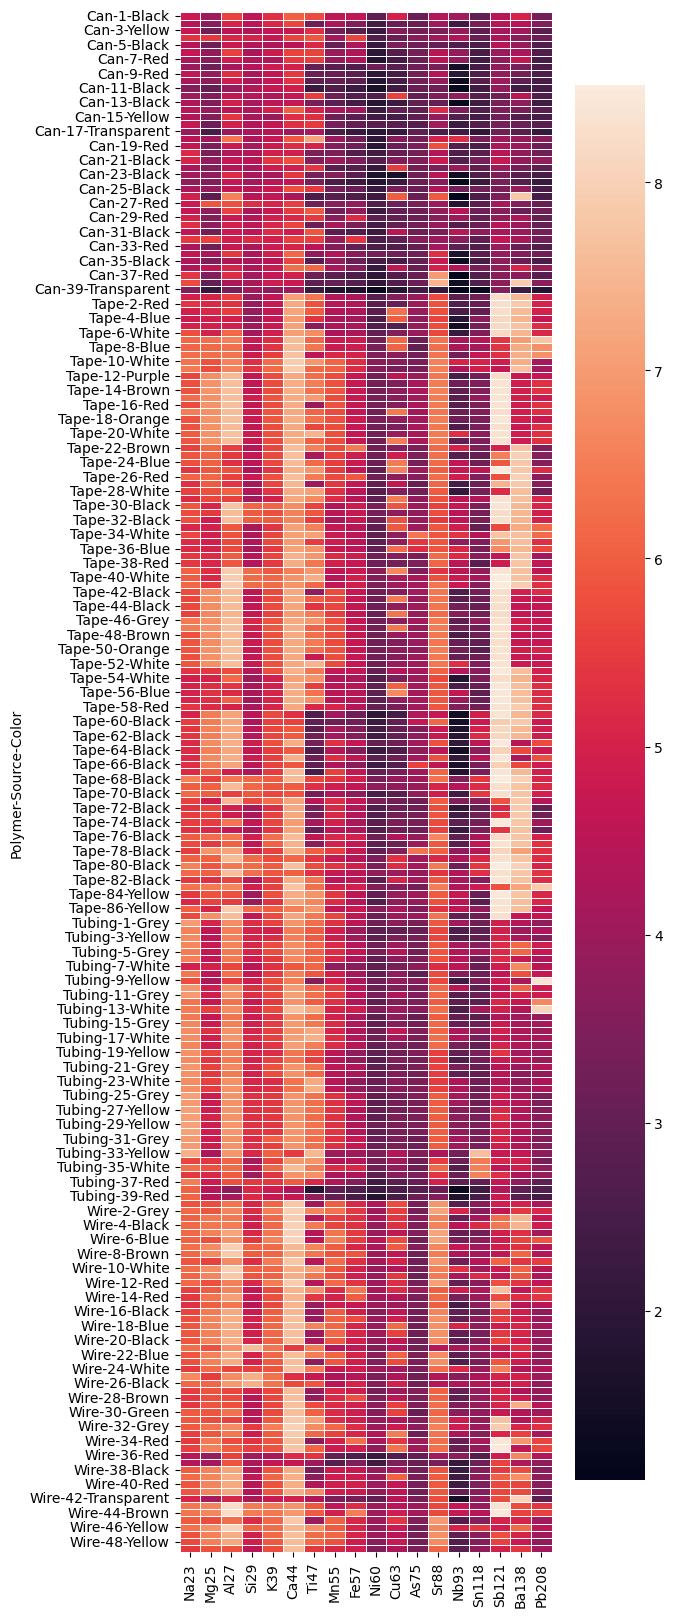

In [8]:
f, ax = plt.subplots(figsize=(6, 20))
sns.heatmap(np.log10(data_mean).replace([np.nan, -np.inf], 0), annot=False, linewidths=.4, ax=ax)

<Axes: >

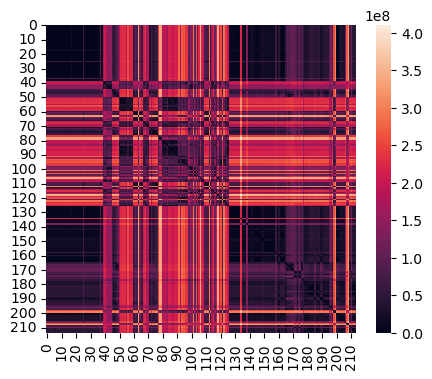

In [9]:
f, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(squareform(pdist(data_mean)))

### Barchart

In [10]:
stats = data_x.agg(['mean', 'std'])[sorted(data_x.columns, key=lambda x: int(re.search(r'\d+', x).group()))] # Sort columns on atomic mass
stats

Na23          Mg25          Al27          Si29            K39  \
mean  1.656843e+06  1.577140e+06  1.400354e+07  6.138267e+05  581324.781764   
std   3.149093e+06  2.281693e+06  2.566270e+07  3.702608e+06  657192.729061   

              Ca44          Ti47           Mn55           Fe57         Ni60  \
mean  1.801598e+07  2.658841e+06  248385.085848  112998.006111  2847.178542   
std   2.127655e+07  5.234105e+06  403727.005382  375136.538346  5317.909541   

               Cu63           As75          Sr88          Nb93         Sn118  \
mean  280922.248149   31437.509604  1.653005e+06  18779.019171  2.758585e+05   
std   786206.666326  234547.101895  2.871121e+06  40518.396912  3.125157e+06   

             Sb121         Ba138         Pb208  
mean  7.200087e+07  1.653338e+07  2.402817e+06  
std   1.048193e+08  2.716854e+07  1.870816e+07

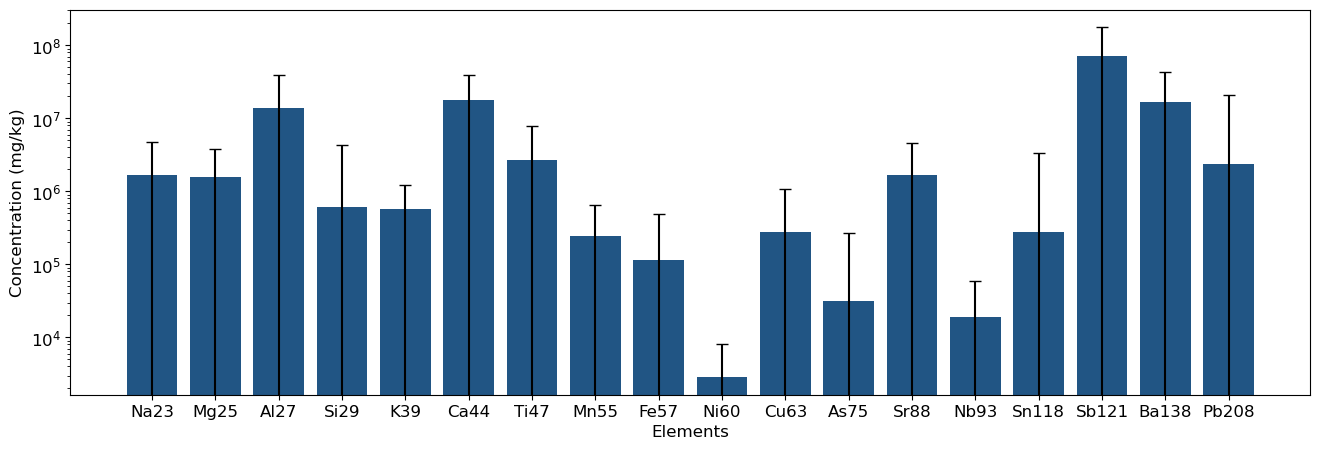

In [11]:
fig, ax = plt.subplots(figsize=(16,5))

ax.bar(stats.columns, stats.loc['mean'], yerr=stats.loc['std'], capsize=4)

plt.ylabel("Concentration (mg/kg)", fontsize = 12) #Counts ($\mathregular{s^{-1}}$)
plt.xlabel("Elements", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax.set_yscale('log')

#plt.gcf().subplots_adjust(bottom=0.4, left = 0.05)

#plt.savefig('img/Concentrations_tapes_PVC.svg') # Save image.

### Histograms

Histogram of all measured concentrations:


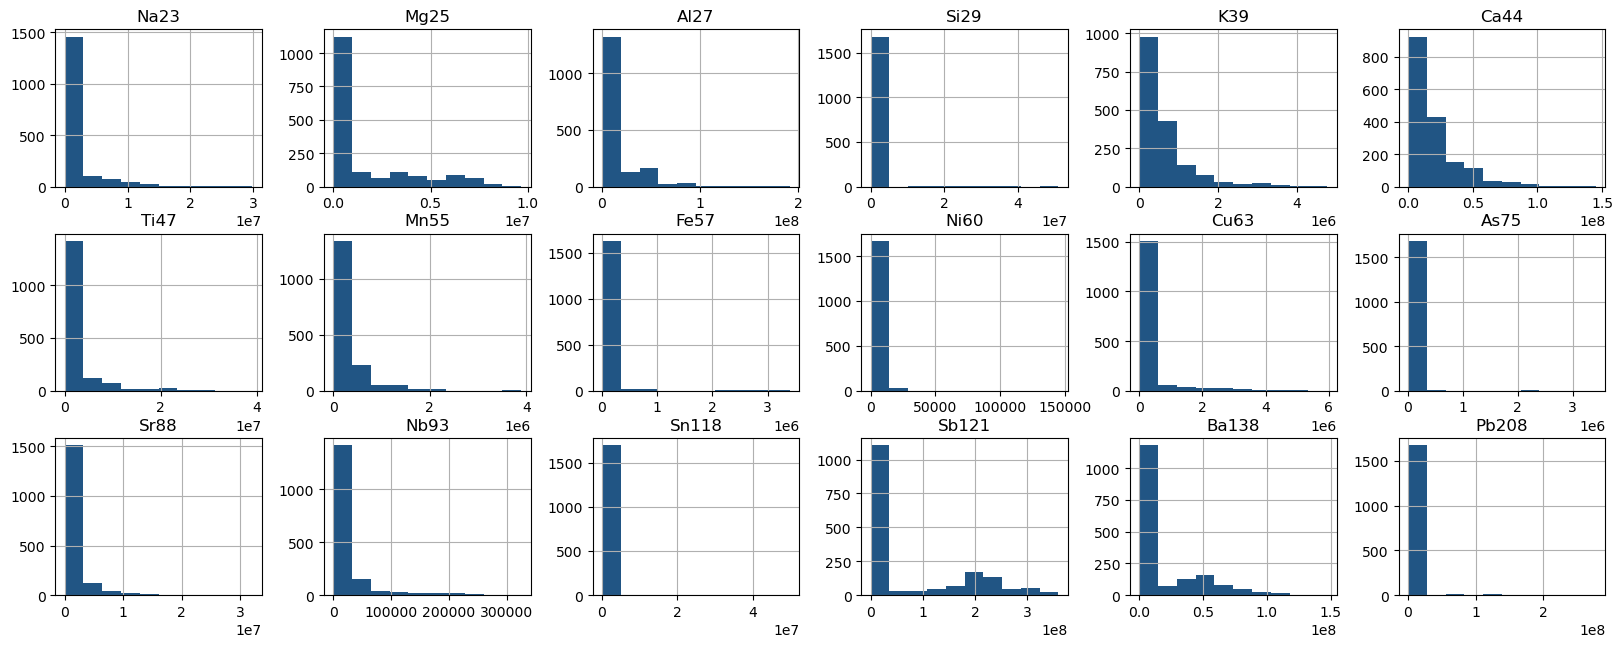

In [12]:
print("Histogram of all measured concentrations:")
data_x.hist(figsize=(20,10), layout=(4,6));

Histogram of all measured concentrations:


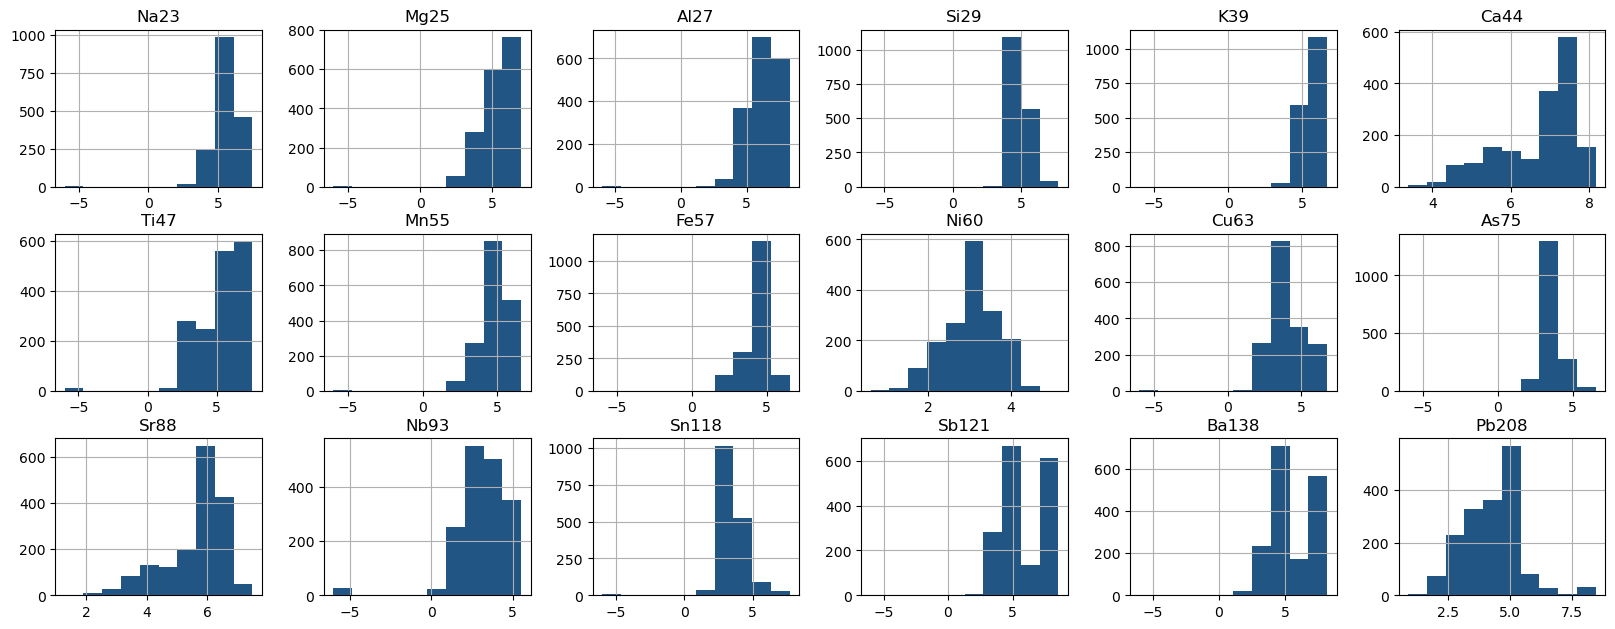

In [13]:
print("Histogram of all measured concentrations:")
data_log.hist(figsize=(20,10), layout=(4,6));

In [14]:
# print("Histograms of standard deviations within objects:")
# data_log.groupby('Source').std().hist(figsize=(20,10), layout=(4,6));

### Correlation

<Axes: >

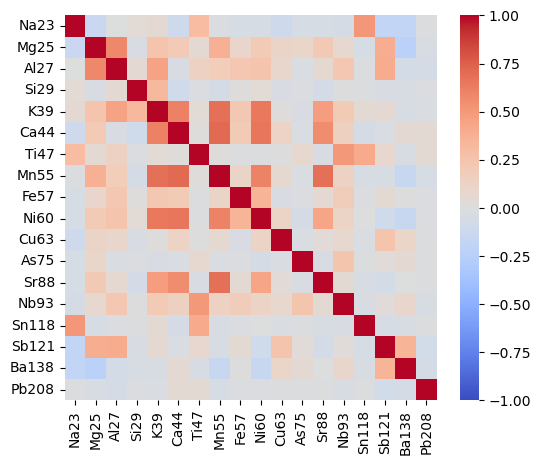

In [15]:
plt.figure(figsize=(6,5))
sns.heatmap(data_mean.corr(), cmap='coolwarm', vmin=-1)

<Axes: >

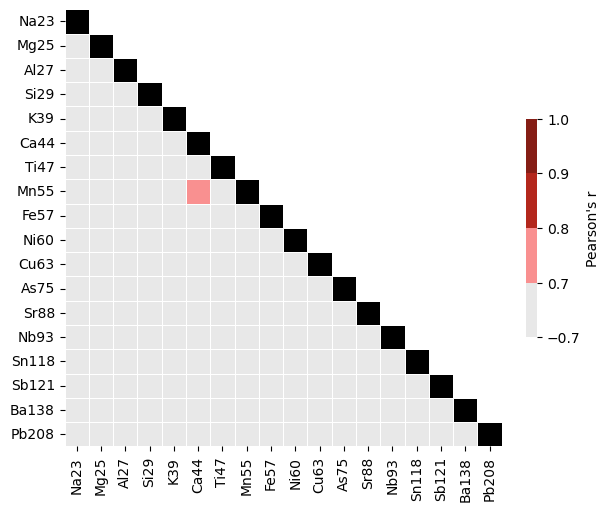

In [16]:
fig, ax = plt.subplots(figsize=(6,5), layout="constrained")

corr = data_mean.corr()

mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

colors = ["#E8E8E8", "#FF7373", "#C22A1E", "#851D15"]
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=5)
cmap.set_over(color="black")

#labels=['Na', 'Mg', 'Al', 'Si', 'Ca', 'Ti', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Ga', 'As', 'Sr', 'Nb', 'Pd', 'Sn', 'Sb', 'Ba', 'Pb']

def func(x):
    if abs(x) < .7:
        return .6
    elif x == 1:
        return 1
    else:
        return x // .1 * .1

sns.heatmap(
    corr.applymap(func), 
#    xticklabels=labels, 
#    yticklabels=labels, 
    mask=mask, 
    cmap=cmap,
    vmin=.6,
    vmax=.99,
    linewidths=.5, 
    fmt='.3f',
    cbar_kws={"shrink": .5, "boundaries": [-.7, .7, .8, .9, 1], "label": "Pearson's r"}, 
    square=True)

#fig.savefig('img/Correlation2.pdf') # Save image.

### Pairplot

C:\Users\mirja\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


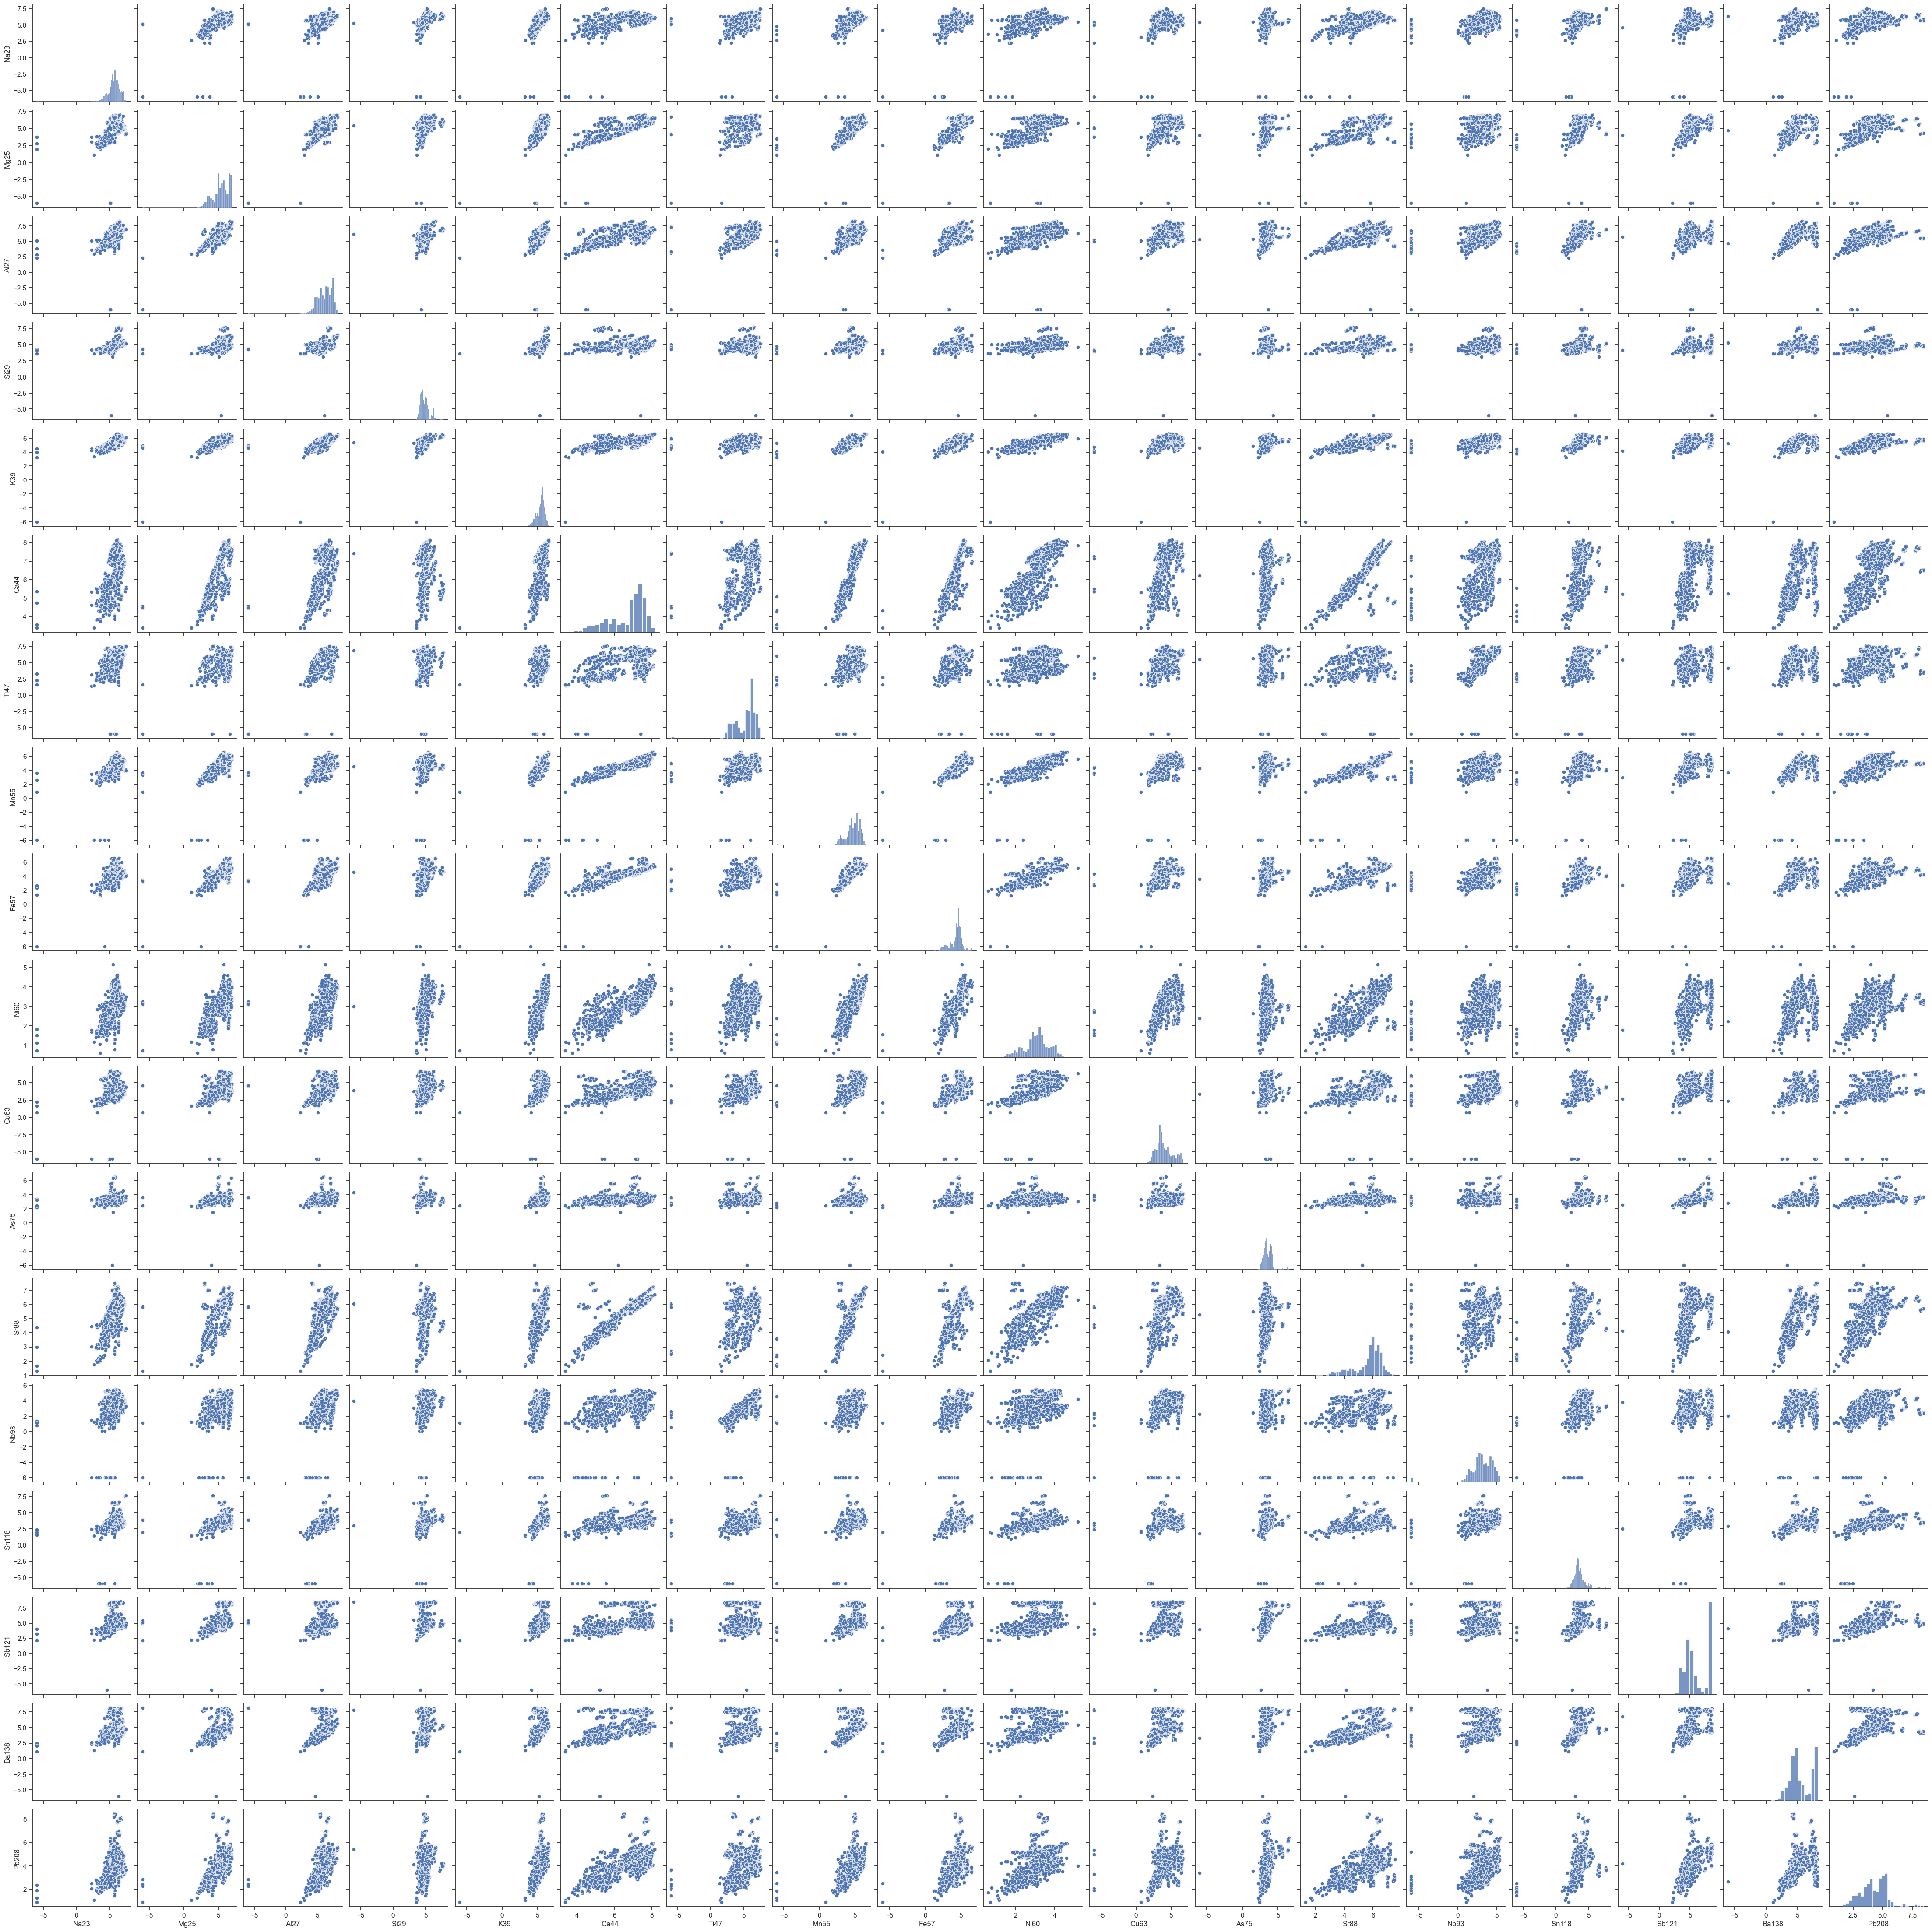

In [17]:
# sns.set_theme(style='ticks')
# sns.pairplot(data_log)

# #plt.savefig('img/Pairplot.svg') # Save image.

# plt.show()
# plt.close()

### Boxplot

In [18]:
unique_colors = data_x.reset_index()['Color'].unique()
#data_x.xs(level='Color', key='Yellow')

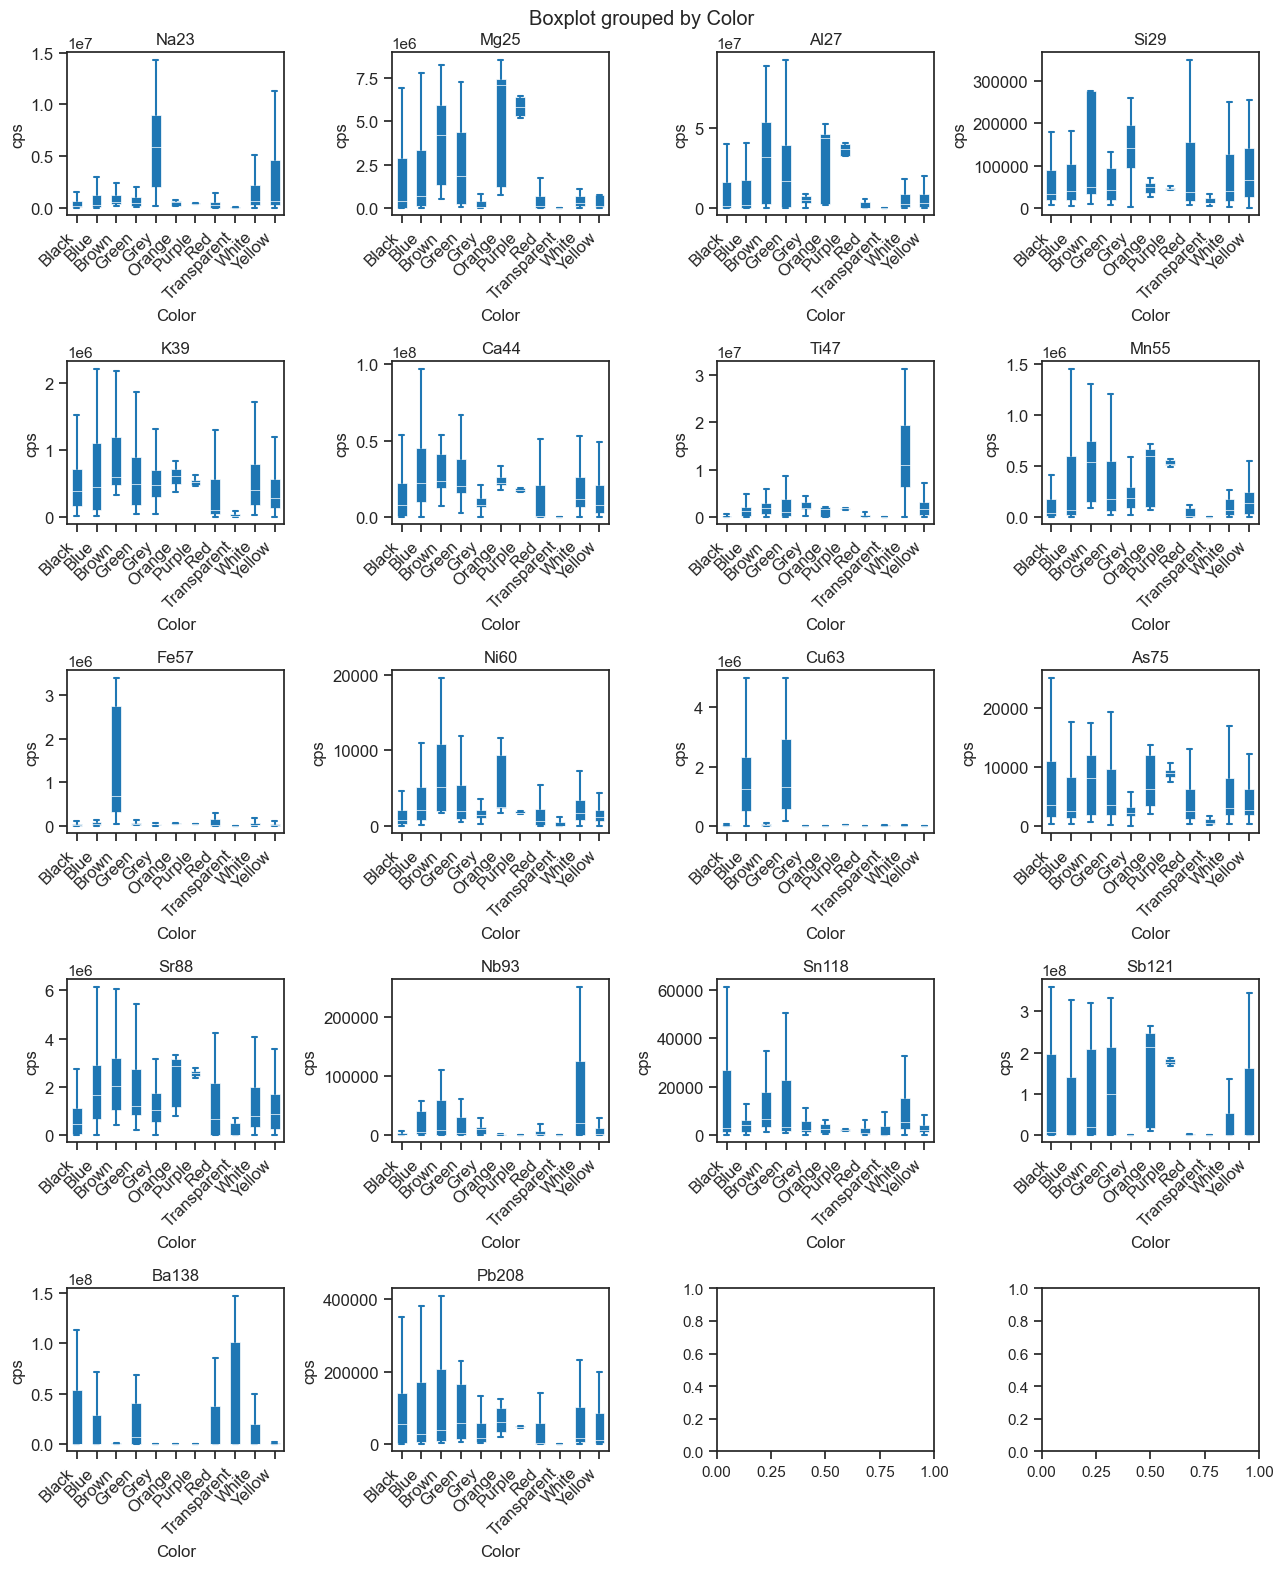

In [19]:
fig, axes = plt.subplots(5,4, figsize=(13,16)) # create figure and axes

plt.style.use('_mpl-gallery')

for i,el in enumerate(list(data_x.columns.values)[0:]):
    a = data_x.boxplot(el, by="Color", ax=axes.flatten()[i], grid=False, fontsize=12,  widths=0.5, notch=False, patch_artist=True, showmeans=False, showfliers=False,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white", "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5},
                ylabel='cps' #Concentration (mg/kg)
                       )
    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right', fontsize=12)

plt.tight_layout() 

#plt.savefig('img/Boxplot-color-Ti.svg') # Save image.

plt.show()

## Profiling

The following datasets can be used for further processing (Also the log variation is saved by 'data_FO_log' etc.)
* data_FO (no correction)
* data_FO_C (normalization by C13)
* data_FO_SRM (correction for SRM612 glass)
* data_FO_PVC (in mg/kg, corrected by PVC standards)
* data_FO_C (in mg/kg, but normalized by Ni/Sr/Co abundance)

In [20]:
#data_FO.groupby(['Color']).size().sort_values()
#data_x = data_cps_PE_N.xs(level='Color', key='Yellow')

### Clustermap

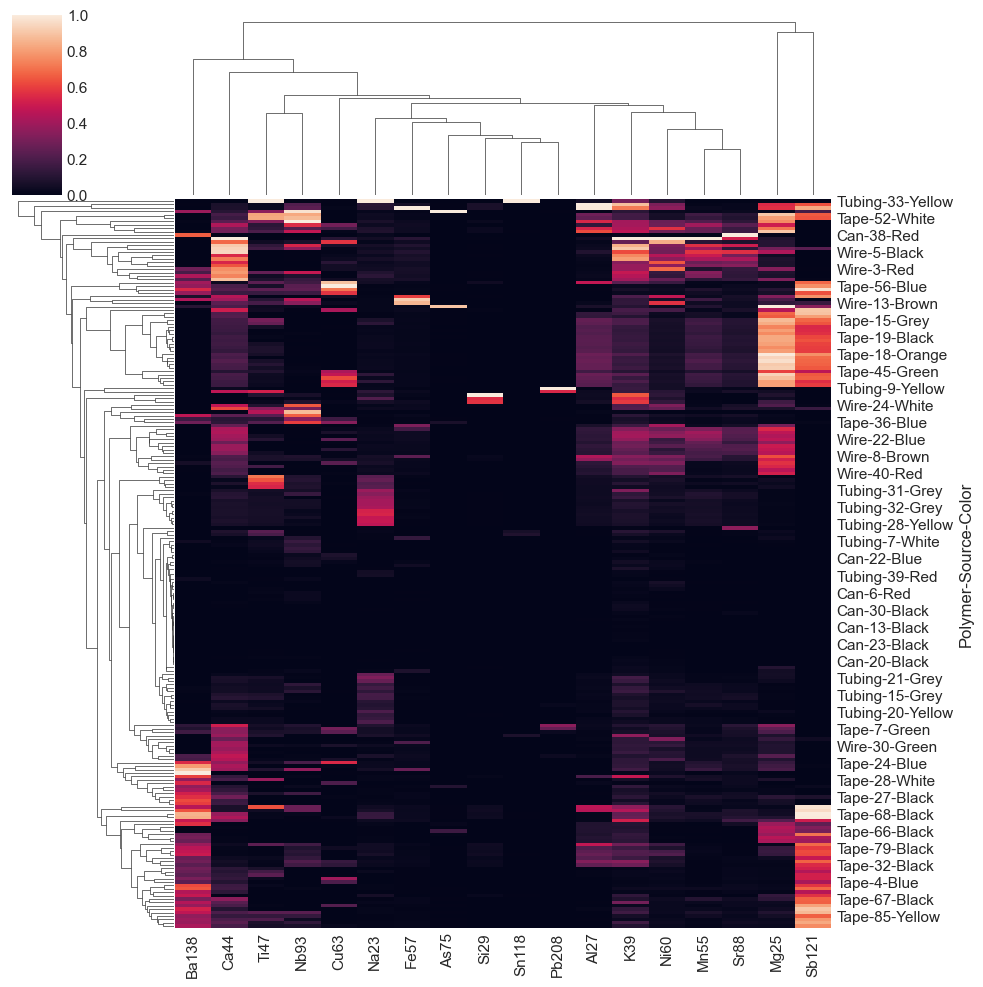

In [21]:
sns.clustermap(data_mean, standard_scale=True)

### PCA

#### Effect of preprocessing

In [22]:
data_x = data_log

In [23]:
pca = PCA()

class NoOpTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X
    
p = Pipeline([('scaler', NoOpTransformer()), ('pca', pca)])
#p['pca']

In [24]:
results = dict(
    no_preprocessing = Pipeline([('scaler', NoOpTransformer()), ('pca', pca)]),
    StandardScaler   = Pipeline([('scaler', StandardScaler()), ('pca', pca)]),
    RobustScaler   = Pipeline([('scaler', RobustScaler()), ('pca', pca)]),
    MinMaxScaler   = Pipeline([('scaler', MinMaxScaler()), ('pca', pca)]),
    MaxAbsScaler   = Pipeline([('scaler', MaxAbsScaler()), ('pca', pca)]),
    QuantileTransformer   = Pipeline([('scaler', QuantileTransformer(n_quantiles=4)), ('pca', pca)]),
    Normalizer   = Pipeline([('scaler', Normalizer()), ('pca', pca)]))

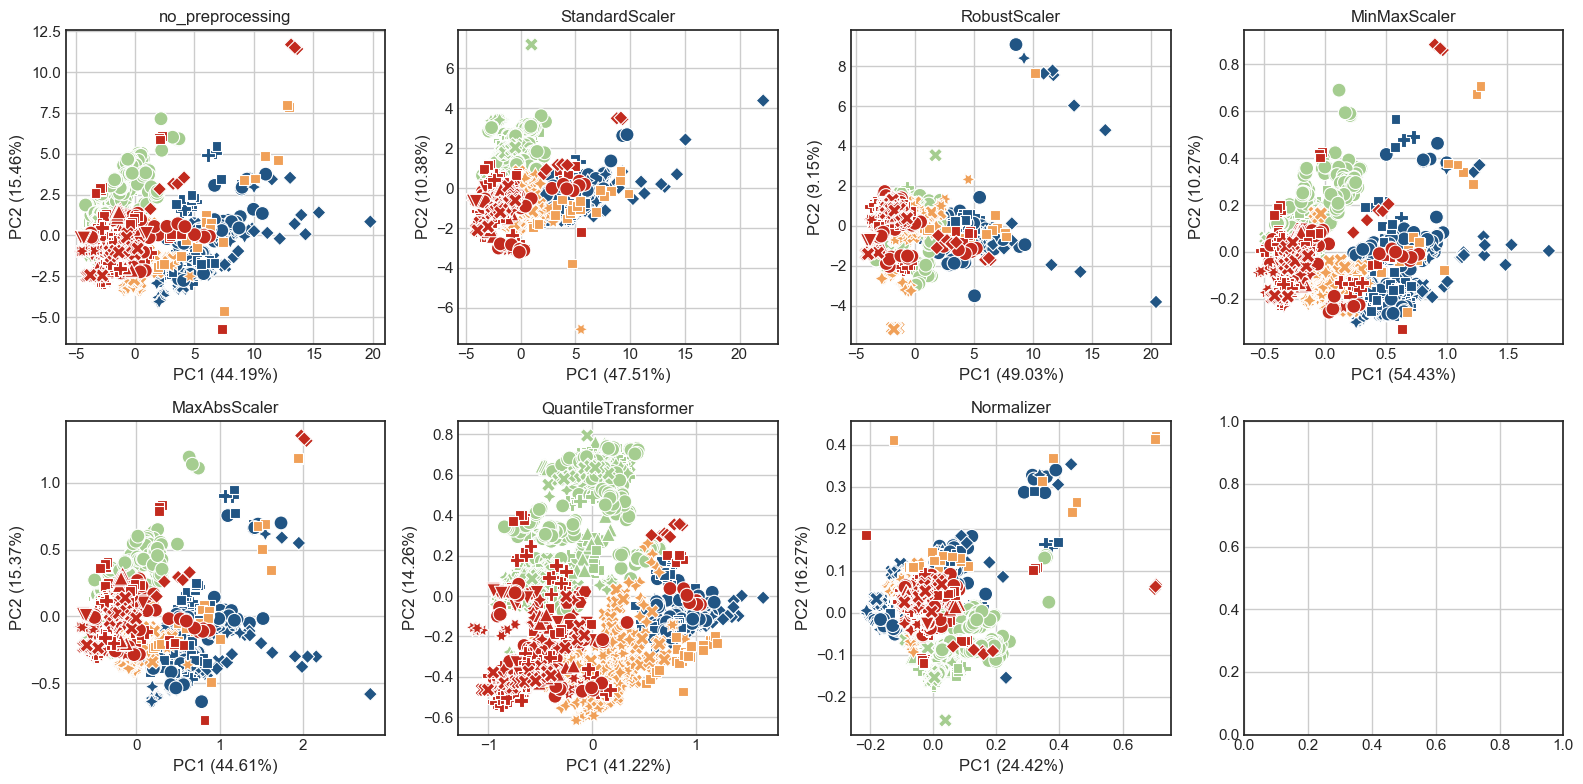

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,8), layout="tight")
for (label, result), ax in zip(results.items(), axs.flatten()):
    model = result.fit(data_x)
    data = pd.DataFrame(model.transform(data_x), index=data_x.index).reset_index()
    sns.scatterplot(data=data, x=0, y=1, hue='Polymer', style="Color", s=100, palette=mycolors4, legend=False, ax=ax) #palette="viridis", 
    ax.set(title=label, xlabel=f"PC1 ({model['pca'].explained_variance_ratio_[0]:.2%})", ylabel=f"PC2 ({model['pca'].explained_variance_ratio_[1]:.2%})")

#### Normalization

In [26]:
cps_norm = pd.DataFrame(QuantileTransformer(n_quantiles=4).fit_transform(data_x), index=data_x.index)
#cps_norm = pd.DataFrame(StandardScaler().fit_transform(data_x), index=data_x.index)

In [27]:
pca = PCA()
pca_data = pd.DataFrame(
    pca.fit_transform(cps_norm), 
    index=data_x.index,
    columns=np.arange(1, cps_norm.shape[1]+1))

#### Leave one out validation

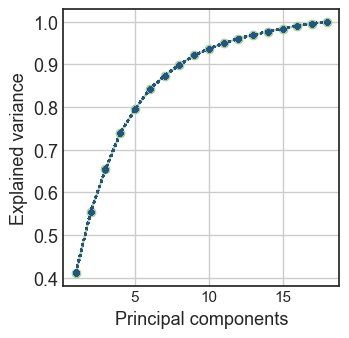

In [28]:
plt.figure(figsize=(4, 3.5))
#plt.figure(figsize=(2.4, 2))

#Leave one out validation
plt.plot(pd.Series(np.cumsum(pca.explained_variance_ratio_), index=np.arange(1, len(pca.explained_variance_ratio_)+1)), marker='o', color='#A5CD90')

for leaveout in cps_norm.index:
    pca = pca.fit(cps_norm.drop(leaveout))
    plt.plot(pd.Series(np.cumsum(pca.explained_variance_ratio_), index=np.arange(1, len(pca.explained_variance_ratio_)+1)), alpha=.4, ls=':', marker='.', color='#215584')
    
plt.xlabel("Principal components", fontsize = 13)
plt.ylabel("Explained variance", fontsize = 13)
# plt.xticks(np.arange(0, 21, step=5),fontsize=13)
# plt.yticks(np.arange(0.6, 1.1, step=0.1),fontsize=13)
#plt.xticks(np.arange(2, 5, step=1),fontsize=13)
#plt.yticks(np.arange(0.7, 0.9, step=0.05),fontsize=13)
#plt.xlim(2.9, 4.1)
#plt.ylim(0.8, 0.86)
plt.yticks(fontsize=13)
plt.gcf().subplots_adjust(bottom=0.2, left = 0.3)

#plt.xaxis.set_minor_locator(MultipleLocator(1))

#plt.savefig('img/Leave-one-out.svg') # Save image.

#### Leave-one-group-out validation

In [29]:
data_x2 = (data_x
           .reset_index()
           .loc[data_x.reset_index()['Polymer'].str.contains('Tubing|Wire|Tape')] #Can|Tape|Tubing|Wire
           .pivot_table(index=['Polymer','Source','Batch','Color','N'])
          )
data_x2

Al27      As75     Ba138      Ca44  \
Polymer Source Batch Color  N                                           
Tape    1      A     Yellow 1  5.631939  3.999330  7.577135  7.139795   
                            2  5.608667  3.980716  7.556832  7.125363   
                            3  5.571420  3.926938  7.506657  7.072232   
                            4  5.548045  3.922605  7.483612  7.025915   
        2      A     Red    1  5.254012  3.977221  7.881754  7.243889   
...                                 ...       ...       ...       ...   
Wire    48     A     Yellow 4  7.179198  3.204958  4.709299  7.503498   
        49     A     Yellow 1  5.801121  3.553745  5.484849  7.636923   
                            2  5.944567  3.396305  4.730706  7.685079   
                            3  5.775303  3.296121  4.559177  7.673056   
                            4  5.815095  3.277200  4.578855  7.649487   

                                   Cu63  Day2      Fe57       K39      Mg25  \
Polymer Source Batch Color  N                                                 
Tape    1      A     Yellow 1  3.642459   1.5  4.271450  4.686154  5.110380   
                            2  3.629416   1.5  4.260070  4.649376  5.105576   
                            3  3.571153   1.5  4.192719  4.610708  5.049880   
                            4  3.621050   1.5  4.155100  4.598900  4.954013   
        2      A     Red    1 -1.387404   1.5  4.348253  4.759700  5.201644   
...                                 ...   ...       ...       ...       ...   
Wire    48     A     Yellow 4  4.778049   1.5  4.781311  5.865188  6.470636   
        49     A     Yellow 1  4.337828   1.5  4.891261  5.743983  5.847869   
                            2  4.280836   1.5  4.960933  5.820893  5.857226   
                            3  4.245617   1.5  4.913802  5.687260  5.840808   
                            4  4.137113   1.5  4.908061  5.637689  5.827229   

                                   Mn55      Na23      Nb93      Ni60  \
Polymer Source Batch Color  N                                           
Tape    1      A     Yellow 1  4.390771  4.993343  2.932963  2.779946   
                            2  4.365892  5.010340  2.896024  2.752502   
                            3  4.341554  4.918622  2.869335  2.738298   
                            4  4.280688  4.900636  2.856455  2.938752   
        2      A     Red    1  4.462383  5.339549  2.552101  2.855280   
...                                 ...       ...       ...       ...   
Wire    48     A     Yellow 4  5.763392  5.640916  2.362144  3.623633   
        49     A     Yellow 1  5.129233  5.477706  2.805125  3.522287   
                            2  5.135703  5.482489  2.606238  3.477912   
                            3  5.170249  5.417238  2.574537  3.544866   
                            4  5.113991  5.367698  2.962911  3.468892   

                                  Pb208     Sb121      Si29     Sn118  \
Polymer Source Batch Color  N                                           
Tape    1      A     Yellow 1  5.002485  8.277278  3.949196  3.348624   
                            2  4.978187  8.254257  3.899878  3.261807   
                            3  4.932696  8.199970  3.845111  3.226967   
                            4  4.920250  8.187687  3.897851  3.140292   
        2      A     Red    1  5.029866  8.289811  3.996639  3.094635   
...                                 ...       ...       ...       ...   
Wire    48     A     Yellow 4  3.748363  5.347261  4.906484  3.598305   
        49     A     Yellow 1  4.140644  5.082782  4.532520  3.879814   
                            2  4.144644  5.001227  4.583455  3.810236   
                            3  4.094801  4.917482  4.452175  3.794004   
                            4  4.055214  4.857897  4.439788  3.758321   

                                   Sr88      Ti47  
Polymer Source Batch Color  N                      
Tape    1      A     Yellow 1  5.761039  6.419555  
 

In [30]:
cps_norm2 = pd.DataFrame(QuantileTransformer(n_quantiles=4).fit_transform(data_x2), index=data_x2.index)

In [31]:
pca2 = PCA()
pca_data2 = pd.DataFrame(
    pca2.fit_transform(cps_norm2), 
    index=data_x2.index,
    columns=np.arange(1, cps_norm2.shape[1]+1))

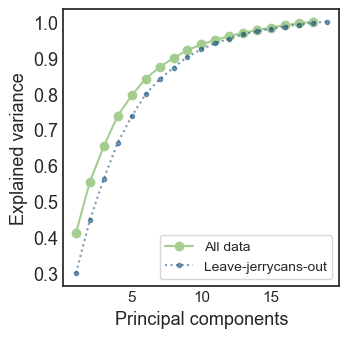

In [32]:
plt.figure(figsize=(4, 3.5))

plt.plot(pd.Series(np.cumsum(pca.explained_variance_ratio_), index=np.arange(1, len(pca.explained_variance_ratio_)+1)), marker='o', color='#A5CD90')
plt.plot(pd.Series(np.cumsum(pca2.explained_variance_ratio_), index=np.arange(1, len(pca2.explained_variance_ratio_)+1)), alpha=.6, ls=':', marker='.', color='#215584')

# for leaveout in cps_norm.index:
#     pca = pca.fit(cps_norm.drop(leaveout))
#     plt.plot(pd.Series(np.cumsum(pca.explained_variance_ratio_), index=np.arange(1, len(pca.explained_variance_ratio_)+1)), alpha=.4, ls=':', marker='.', color='#215584')
    
plt.xlabel("Principal components", fontsize = 13)
plt.ylabel("Explained variance", fontsize = 13)

plt.yticks(fontsize=13)
plt.gcf().subplots_adjust(bottom=0.2, left = 0.3)

a = plt.legend(['All data', 'Leave-jerrycans-out'], fontsize=10)

plt.grid(False)

#plt.savefig('img/PCA-Leave-cans-out.svg') # Save image.

#### Score plot

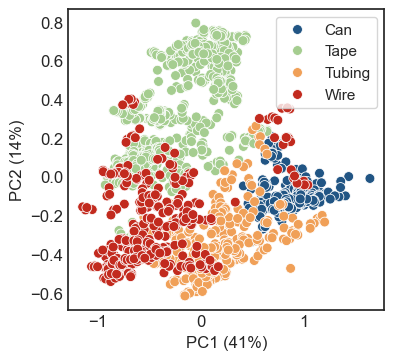

In [33]:
plt.figure(figsize=(4,3.8))

sns.scatterplot(data=pca_data.reset_index(), x=1, y=2, hue='Polymer', s=50, legend=True, palette=mycolors4)
plt.xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0],2):.0%})', fontsize = 12)
plt.ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1],2):.0%})', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize=11)

plt.gcf().subplots_adjust(left=0.2, bottom=0.2)

plt.grid(False)

#plt.savefig('img/PCA_Classification-data_FO_PVC-Ti.svg') # Save image.

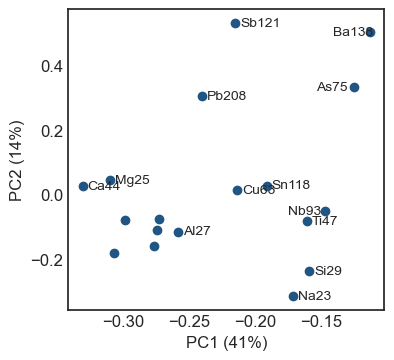

In [35]:
plt.figure(figsize=(4,3.8))

loadings = pd.DataFrame(pca.components_, columns=data_x.columns).T[[0, 1]]

plt.scatter(loadings[0], loadings[1], color="#215584")
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.0%})', fontsize = 12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.0%})', fontsize = 12)
for label, x, y in loadings.itertuples():
    if x<-0.15 and x>-0.27: #or x>0.1
        plt.annotate(label, (x, y), xytext=(5, -3), textcoords=('offset pixels', 'offset pixels'), fontsize=10)
    if x>-0.15: #or x>0.1
        plt.annotate(label, (x, y), xytext=(-37, -3), textcoords=('offset pixels', 'offset pixels'), fontsize=10)
    if x<-0.27 and y<0.075 and y>0: #or x>0.1
        plt.annotate(label, (x, y), xytext=(5, -3), textcoords=('offset pixels', 'offset pixels'), fontsize=10)
    if x<-0.27 and y>0.095: #or x>0.1
        plt.annotate(label, (x, y), xytext=(0, 5), textcoords=('offset pixels', 'offset pixels'), fontsize=10)
    if x<-0.27 and y>0.065 and y<0.085: #or x>0.1
        plt.annotate(label, (x, y), xytext=(2, -10), textcoords=('offset pixels', 'offset pixels'), fontsize=10)

plt.xticks(np.arange(-0.3,-0.1, step=0.05), fontsize=12)
plt.yticks(fontsize=12) #(np.arange(-0.6,0.8, step=0.2), fontsize=15)

plt.gcf().subplots_adjust(left=0.2, bottom=0.2)

plt.grid(False)

plt.savefig('img/PCA_classification_loadings-Ti.svg') # Save image.

### LDA

In [56]:
data_norm_lda = pd.DataFrame(QuantileTransformer(n_quantiles=4).fit_transform(data_log), index=data_log.index) #StandardScaler()

clf = LinearDiscriminantAnalysis()
clf.fit(X=data_norm_lda, y=data_norm_lda.index.get_level_values('Polymer'))

lda = pd.DataFrame(clf.transform(data_norm_lda)[:,0:2], index=data_norm_lda.index)
lda

0         1
Polymer Source Day2 Batch Color  N                    
Can     1      1    A     Black  1 -2.759373 -1.677836
                                 2 -2.872702 -1.581218
                                 3 -2.932603 -1.587748
                                 4 -3.041112 -1.543906
               2    A     Black  1 -3.318957 -2.024278
...                                      ...       ...
Wire    49     1    A     Yellow 4 -0.996084 -3.026661
               2    A     Yellow 1 -0.822263 -2.913692
                                 2 -0.647856 -2.983737
                                 3 -0.984103 -2.868918
                                 4 -0.981513 -2.928569

[1704 rows x 2 columns]

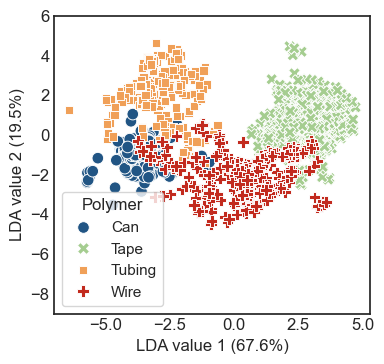

In [57]:
plt.figure(figsize=(4,3.8))

#sns.scatterplot(x=lda[0], y=np.ones(len(lda)), hue=cps_wire.index.get_level_values('Sample'))
sns.scatterplot(x=lda[0], y=lda[1], hue=data_x.index.get_level_values('Polymer'), style=data_x.index.get_level_values('Polymer'), s=70, palette=mycolors4, legend=True)
plt.xlabel(f'LDA value 1 ({clf.explained_variance_ratio_[0]:.01%})', fontsize = 12)
plt.ylabel(f'LDA value 2 ({clf.explained_variance_ratio_[1]:.01%})', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
#plt.legend([])

plt.gcf().subplots_adjust(left=0.2, bottom=0.2)

plt.ylim(-9, 6)

plt.grid(False)

plt.tight_layout()

#plt.savefig('img/LDA_Classification.svg') # Save image.

In [58]:
loadings_lda = pd.DataFrame(clf.scalings_.T[0:2], columns=data_x.columns).loc[0:1]

C:\Users\mirja\AppData\Local\Temp\ipykernel_22804\2100423976.py:3: UserWarning: 
The palette list has fewer values (1) than needed (18) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=loadings_lda.T.reset_index(), x=0, y=1, hue='index', legend=False, palette=["#215584"])


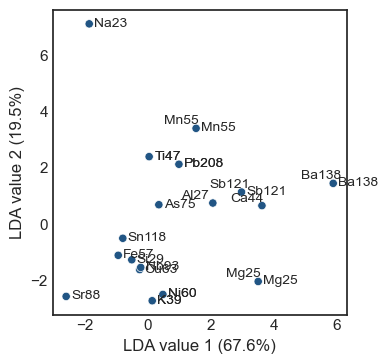

In [59]:
plt.figure(figsize=(4,3.8))

sns.scatterplot(data=loadings_lda.T.reset_index(), x=0, y=1, hue='index', legend=False, palette=["#215584"])
plt.xlabel(f'LDA value 1 ({clf.explained_variance_ratio_[0]:.01%})', fontsize = 12)
plt.ylabel(f'LDA value 2 ({clf.explained_variance_ratio_[1]:.01%})', fontsize = 12)

for label, x, y in loadings_lda.T.itertuples():
    if x>0.04 and x<1: #or x>0.1
        plt.annotate(label, (x, y), xytext=(5, -3), textcoords=('offset pixels', 'offset pixels'), fontsize=10)
    if x<0.04 and x>0 or x>1: #or x>0.1
        plt.annotate(label, (x, y), xytext=(-32, 4), textcoords=('offset pixels', 'offset pixels'), fontsize=10)
    if x<0 and x<-0.2 or y>1 or y<-0.7: #or x>0.1
        plt.annotate(label, (x, y), xytext=(5, -3), textcoords=('offset pixels', 'offset pixels'), fontsize=10)

# plt.xticks(np.arange(-0.5, 1.25, step=0.5), fontsize=12)
# plt.yticks(np.arange(-1, 4, step=1), fontsize=12)
# plt.xlim(-0.7,1.2)
    
# plt.legend(loc='upper center', bbox_to_anchor=(0.45, -0.2),
#           fancybox=True, shadow=True, ncol=5)

plt.grid(False)

plt.tight_layout()

#plt.savefig('img/LDA_classification_loadings.svg') # Save image.

### t-SNE

<Axes: >

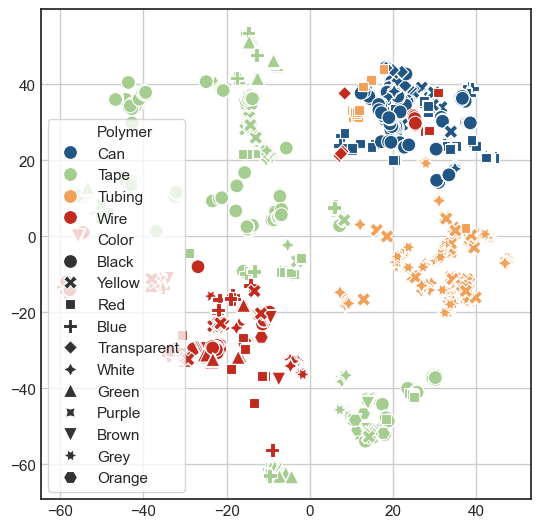

In [65]:
fig, ax = plt.subplots(figsize=(5,5))
scaler = StandardScaler()
embedding = TSNE(init='random', perplexity=25, random_state=20).fit_transform(scaler.fit_transform(data_x))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=data_x.index.get_level_values('Polymer'), style=data_x.index.get_level_values('Color'), palette=mycolors4, ax=ax, s=100)